# 1. Import data and libraries

In [81]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

In [82]:
warnings.filterwarnings("ignore")

In [83]:
plt.style.use('fivethirtyeight')

In [84]:
# Configure API key 
quandl.ApiConfig.api_key = 'ZzTiDLXz2UwZuqA6mS26'

In [85]:
# Importing CPIAUCSL (Consumer Price Index for All Urban Consumers: All Items)
data = quandl.get('FRED/CPIAUCSL')

# 2. Subsetting the data and creating a line chart

In [86]:
data.head(5)

,Value
Date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [87]:
data.shape

(901, 1)

In [88]:
data.columns

Index(['Value'], dtype='object')

In [89]:
type(data)

pandas.core.frame.DataFrame

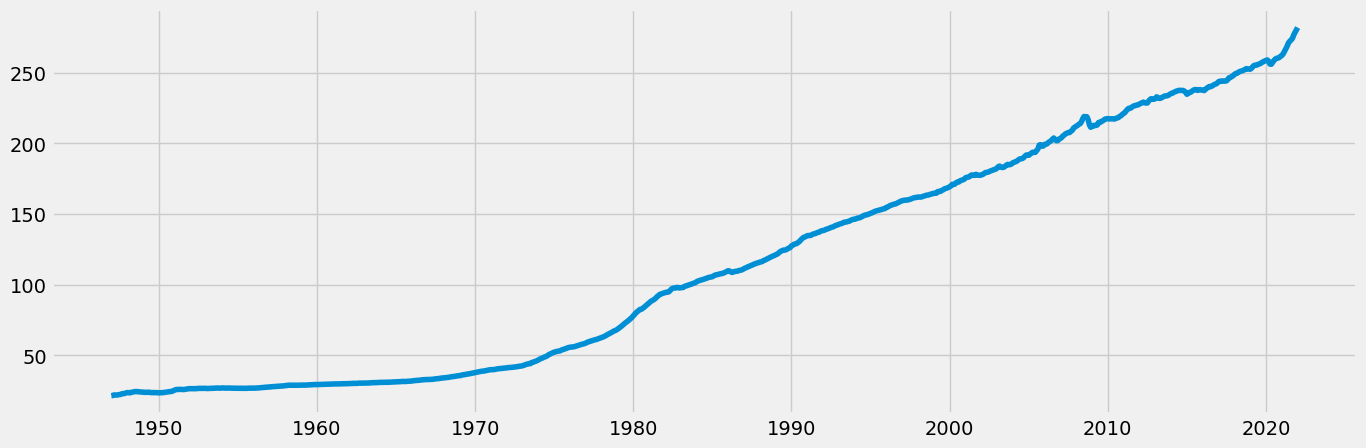

In [90]:
# Plot the data using matplotlib
plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

In [91]:
# Reseting index to access the 'Date' column for filtering
data_2 = data.reset_index()

In [92]:
data_2.head()

,Date,Value
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


In [93]:
# Creating a subset of data from 1980 to 2022
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2022-12-31')]

In [94]:
# Set the 'Date' column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from 'Date'.
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the 'Date' column.
data_sub.head()

,Value
datetime,
1980-01-01,78.0
1980-02-01,79.0
1980-03-01,80.1
1980-04-01,80.9
1980-05-01,81.7


In [95]:
data_sub.shape

(505, 1)

In [96]:
data_sub.head()

,Value
datetime,
1980-01-01,78.0
1980-02-01,79.0
1980-03-01,80.1
1980-04-01,80.9
1980-05-01,81.7


In [97]:
data_sub

,Value
datetime,
1980-01-01,78.000
1980-02-01,79.000
1980-03-01,80.100
1980-04-01,80.900
1980-05-01,81.700
...,...
2021-09-01,274.214
2021-10-01,276.590
2021-11-01,278.524


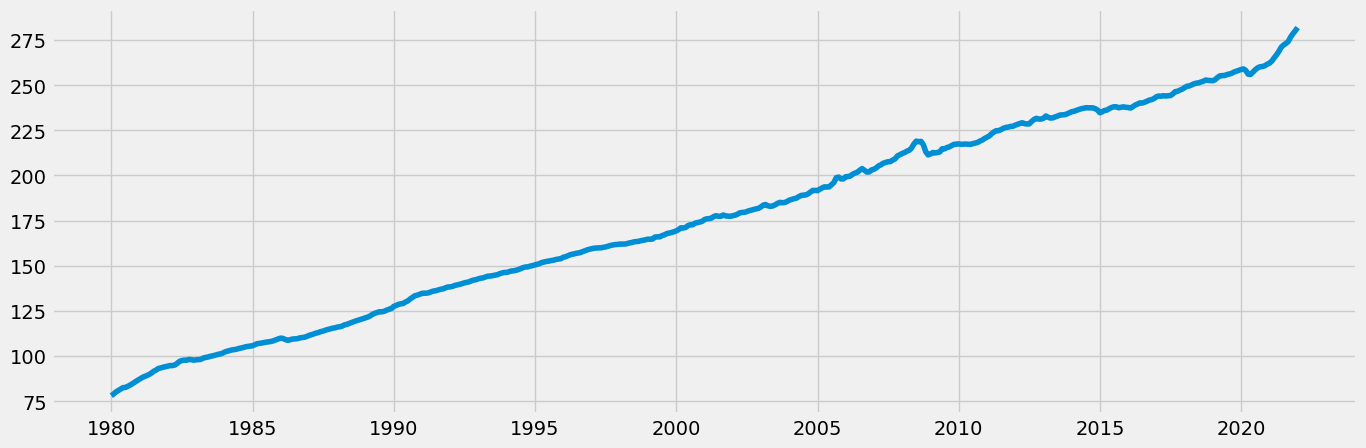

In [98]:
# Plot the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

## The chart illustrates the trajectory of inflation in urban consumer prices spanning four decades, emphasizing the general rise in the overall cost of living.

In [99]:
# Check for missing values
data_sub.isnull().sum() 

Value    0
dtype: int64

In [100]:
# Check for duplicates
dups = data_sub.duplicated()
dups.sum()

24

# 3. Decomposing the data’s components

In [101]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [102]:
from pylab import rcParams # This will define a fixed size for all special charts
rcParams['figure.figsize'] = 18, 7

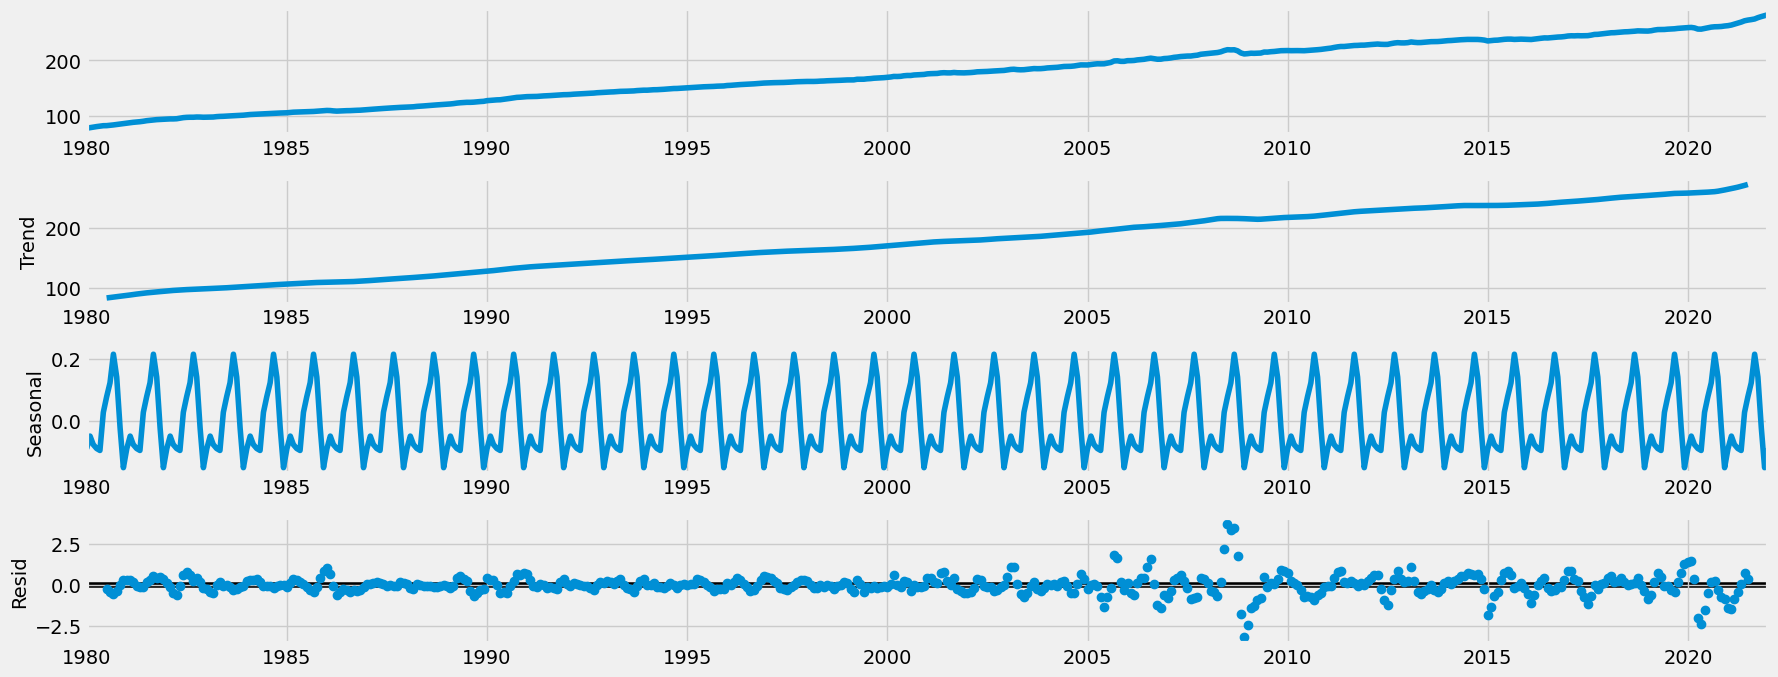

In [103]:
# Plot the separate components
decomposition.plot()
plt.show()

## CPI Analysis (1980-2022)

### Long-Term Trend: A noticeable and consistent upward movement signifies persistent inflation.
### Seasonal Patterns: Predictable and consistent annual fluctuations indicate unchanged seasonal impacts.
### Irregularities: Random variations without a discernible pattern point to effectively captured trends and seasonality.

### In summary, the examination reveals a sustained inflationary trend and consistent seasonal patterns throughout the last four decades.

# 4. Testing for stationarity

In [104]:
# The adfuller() function will import from the model from statsmodels for the test.
# However, running it will only return an array of numbers. 
# This is why we need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.313414
p-value                          0.996683
Number of Lags Used             15.000000
Number of Observations Used    489.000000
Critical Value (1%)             -3.443794
Critical Value (5%)             -2.867469
Critical Value (10%)            -2.569928
dtype: float64


### Test Statistic: 1.313 (exceeds critical values).
### p-value: Approximately 0.997 (signifying non-stationarity).
### Critical Values: -3.444 (1%), -2.867 (5%), -2.570 (10%).

### Summary:
### Given the positive test statistic and a significantly high p-value, it indicates that the CPI data lacks stationarity, implying a fluctuating mean over time. To achieve stationarity, additional differencing is necessary.

# 5. Stationarizing the data. Conduct a round of differencing

In [105]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [106]:
data_diff.dropna(inplace = True) # Here, we remove the missing values that came about as a result of the differencing. 
# We need to remove these or we won't be able to run the Dickey-Fuller test.

In [107]:
data_diff.head()

,Value
datetime,
1980-02-01,1.0
1980-03-01,1.1
1980-04-01,0.8
1980-05-01,0.8
1980-06-01,0.8


In [108]:
data_diff.columns

Index(['Value'], dtype='object')

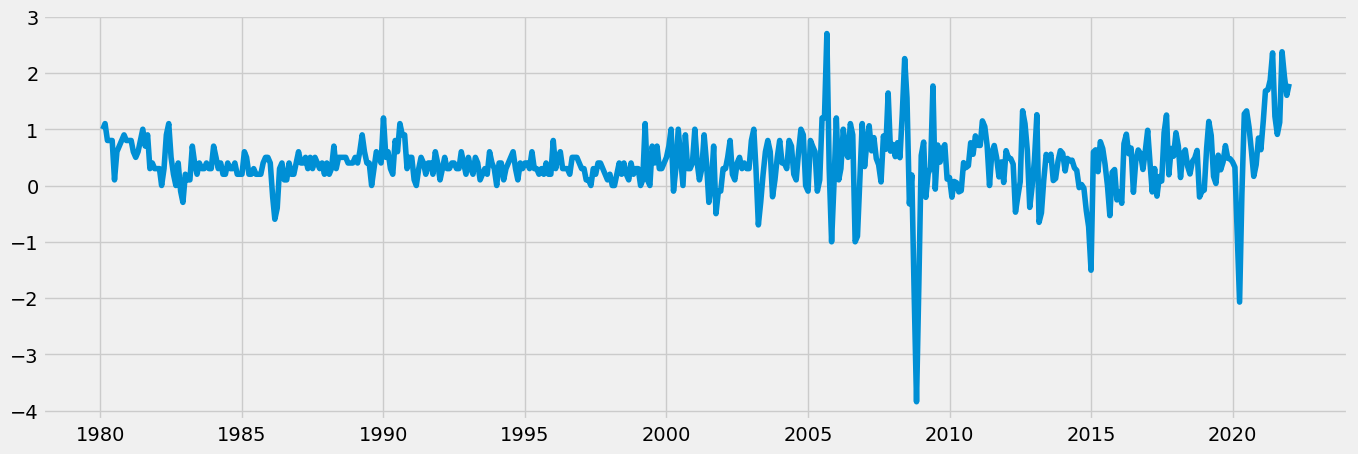

In [109]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [110]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -3.344427
p-value                          0.013006
Number of Lags Used             14.000000
Number of Observations Used    489.000000
Critical Value (1%)             -3.443794
Critical Value (5%)             -2.867469
Critical Value (10%)            -2.569928
dtype: float64


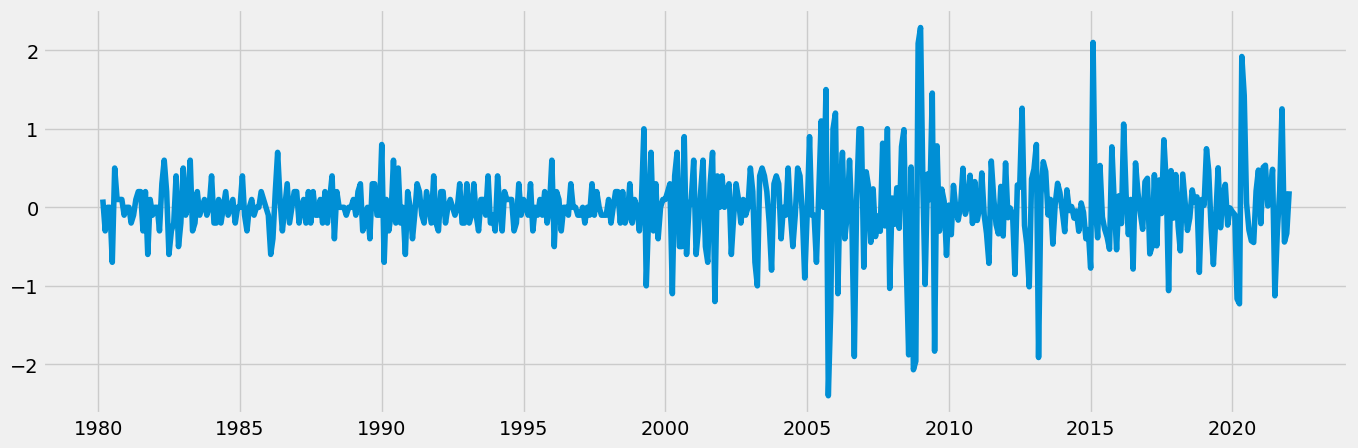

In [111]:
# Performing the second round of differencing
data_diff_2 = data_diff.diff().dropna()

# Plot the twice-differenced data
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(data_diff_2)

In [112]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -1.030452e+01
p-value                        3.305546e-18
Number of Lags Used            1.300000e+01
Number of Observations Used    4.890000e+02
Critical Value (1%)           -3.443794e+00
Critical Value (5%)           -2.867469e+00
Critical Value (10%)          -2.569928e+00
dtype: float64


### The calculated test statistic is significantly more negative than the critical values at the 1%, 5%, and 10% confidence levels. 
### This provides substantial evidence to confidently reject the null hypothesis that a unit root is present. 
### Additionally, the p-value is virtually zero, well below the commonly accepted significance level of 0.05, strongly indicating that the series is indeed stationary.

# 6. Data's autocorrelation

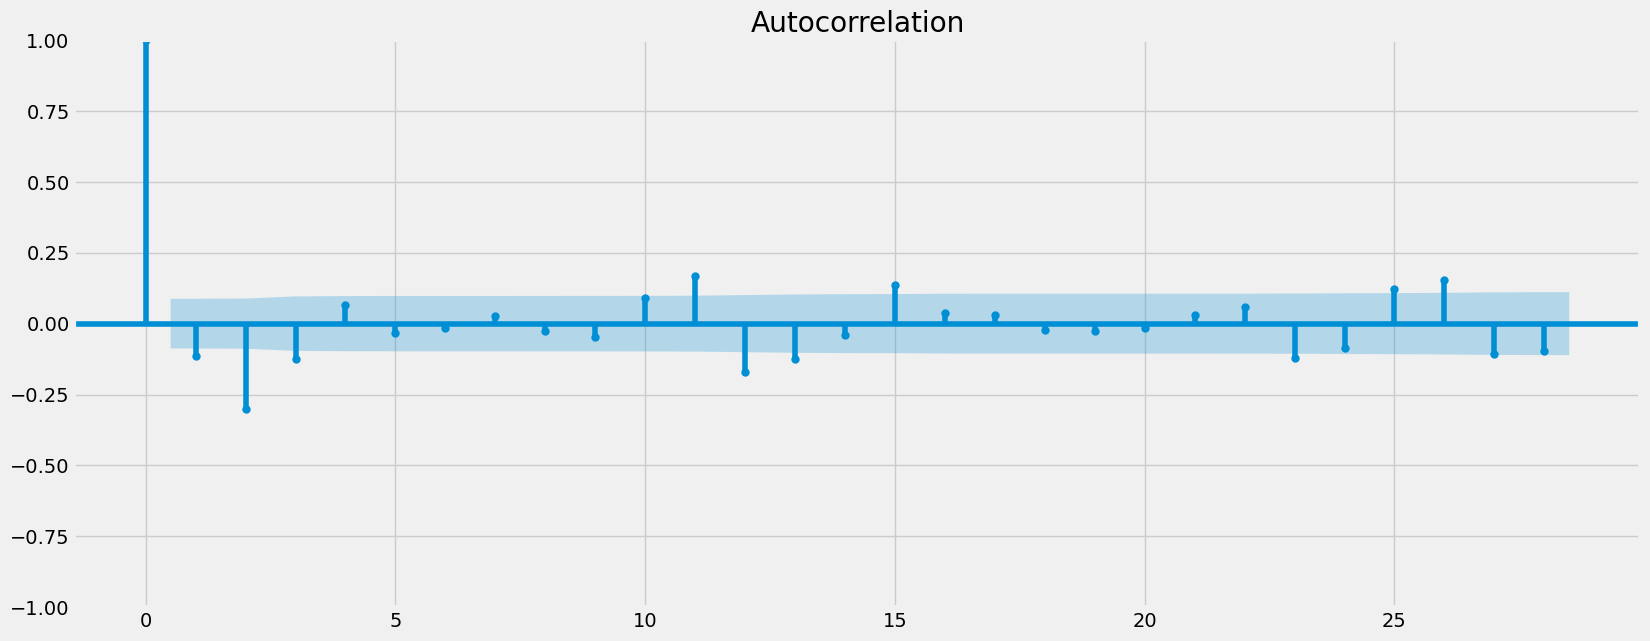

In [113]:
# Check out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, we import the autocorrelation and partial correlation plots

plot_acf(data_diff_2)
plt.show()

## Analysis of ACF Plot

### At Lag 0, the autocorrelation is as anticipated, registering at 1.
### For Subsequent Lags, a notable spike is observed at lag 1, while other lags mostly fall within the confidence interval, signifying minimal autocorrelation.
### In Summary, the ACF plot affirms that the twice-differenced CPI data is predominantly noise, supporting its stationarity. The initial spike implies a potential consideration for an autoregressive term in future modeling.